In [1]:
import os
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up paths - navigate from src/analysis to data directory
try:
    BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
except NameError:
    # Fallback for notebooks - go up two directories from current working directory
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

DATA_DIR = os.path.join(BASE_DIR, 'data')
START_YEAR = 1950
END_YEAR = 2024

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Year range: {START_YEAR} to {END_YEAR}")


/home/nab/anaconda3/envs/dataLiteracy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Base directory: /home/nab/GroupDataLiteracy
Data directory: /home/nab/GroupDataLiteracy/data
Year range: 1950 to 2024


In [2]:
# Load all embeddings and corresponding movie IDs
all_embeddings = []
all_movie_ids = []
all_years = []

for year in range(START_YEAR, END_YEAR + 1):
    embeddings_path = os.path.join(DATA_DIR, f'movie_embeddings_{year}.npy')
    movie_ids_path = os.path.join(DATA_DIR, f'movie_ids_{year}.npy')
    
    if os.path.exists(embeddings_path) and os.path.exists(movie_ids_path):
        embeddings = np.load(embeddings_path)
        movie_ids = np.load(movie_ids_path)
        
        all_embeddings.append(embeddings)
        all_movie_ids.append(movie_ids)
        all_years.extend([year] * len(movie_ids))
        
        print(f"Loaded year {year}: {len(movie_ids)} movies")

# Concatenate all embeddings
all_embeddings = np.vstack(all_embeddings)
all_movie_ids = np.concatenate(all_movie_ids)
all_years = np.array(all_years)

print(f"\nTotal movies: {len(all_movie_ids)}")
print(f"Embedding shape: {all_embeddings.shape}")


Loaded year 1950: 1393 movies
Loaded year 1951: 1220 movies
Loaded year 1952: 1194 movies
Loaded year 1953: 1358 movies
Loaded year 1954: 1162 movies
Loaded year 1955: 1171 movies
Loaded year 1956: 1111 movies
Loaded year 1957: 1190 movies
Loaded year 1958: 1152 movies
Loaded year 1959: 1149 movies
Loaded year 1960: 1150 movies
Loaded year 1961: 1068 movies
Loaded year 1962: 1158 movies
Loaded year 1963: 1053 movies
Loaded year 1964: 1234 movies
Loaded year 1965: 1226 movies
Loaded year 1966: 1176 movies
Loaded year 1967: 1290 movies
Loaded year 1968: 1381 movies
Loaded year 1969: 1363 movies
Loaded year 1970: 1439 movies
Loaded year 1971: 1550 movies
Loaded year 1972: 1592 movies
Loaded year 1973: 1620 movies
Loaded year 1974: 1711 movies
Loaded year 1975: 1712 movies
Loaded year 1976: 1683 movies
Loaded year 1977: 1813 movies
Loaded year 1978: 1846 movies
Loaded year 1979: 1869 movies
Loaded year 1980: 1977 movies
Loaded year 1981: 1683 movies
Loaded year 1982: 1811 movies
Loaded yea

In [3]:
# Load movie metadata from CSV files to get genres
movie_data_list = []
for year in range(START_YEAR, END_YEAR + 1):
    csv_path = os.path.join(DATA_DIR, f'wikidata_movies_{year}.csv')
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path, dtype=str)
        # Select only the relevant columns
        df_year = df[['movie_id', 'genre', 'title']].copy()
        df_year['year'] = year
        movie_data_list.append(df_year)

# Combine all movie data
movie_data = pd.concat(movie_data_list, ignore_index=True)

# Create a mapping from movie_id to genre
movie_to_genre = {}
movie_to_title = {}

for idx, row in movie_data.iterrows():
    movie_id = row['movie_id']
    genre = row['genre']
    title = row['title']
    
    movie_to_title[movie_id] = title
    
    # Extract first genre if multiple genres are separated by commas
    if pd.notna(genre) and genre.strip():
        # Split by comma and take the first genre
        first_genre = genre.split(',')[0].strip()
        movie_to_genre[movie_id] = first_genre
    else:
        movie_to_genre[movie_id] = 'Unknown'

print(f"Loaded metadata for {len(movie_data)} movies")
print(f"Unique movie_ids with metadata: {len(movie_to_genre)}")


Loaded metadata for 214682 movies
Unique movie_ids with metadata: 195122


In [4]:
# Sample 5000 random points for visualization
n_samples = 5000
sample_indices = np.random.choice(len(all_movie_ids), size=n_samples, replace=False)

sampled_embeddings = all_embeddings[sample_indices]
sampled_movie_ids = all_movie_ids[sample_indices]
sampled_years = all_years[sample_indices]

# Extract genres for sampled movies
sampled_genres = [movie_to_genre.get(mid, 'Unknown') for mid in sampled_movie_ids]

print(f"Sampled {n_samples} movies for visualization")
print(f"Year range in sample: {sampled_years.min()} - {sampled_years.max()}")
print(f"Number of unique genres: {len(set(sampled_genres))}")

# Display genre distribution
genre_counts = pd.Series(sampled_genres).value_counts()
print(f"\nTop 10 genres in sample:")
print(genre_counts.head(10))


Sampled 5000 movies for visualization
Year range in sample: 1950 - 2024
Number of unique genres: 187

Top 10 genres in sample:
drama film          1594
Unknown              804
comedy film          527
documentary film     400
action film          219
horror film          203
fantasy film         113
romantic comedy       88
comedy drama          85
thriller film         85
Name: count, dtype: int64


In [5]:
# Create UMAP reduction
print("Computing UMAP reduction...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.1)
umap_embedding = reducer.fit_transform(sampled_embeddings)

print(f"UMAP embedding shape: {umap_embedding.shape}")


Computing UMAP reduction...


/home/nab/anaconda3/envs/dataLiteracy/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (5000, 2)


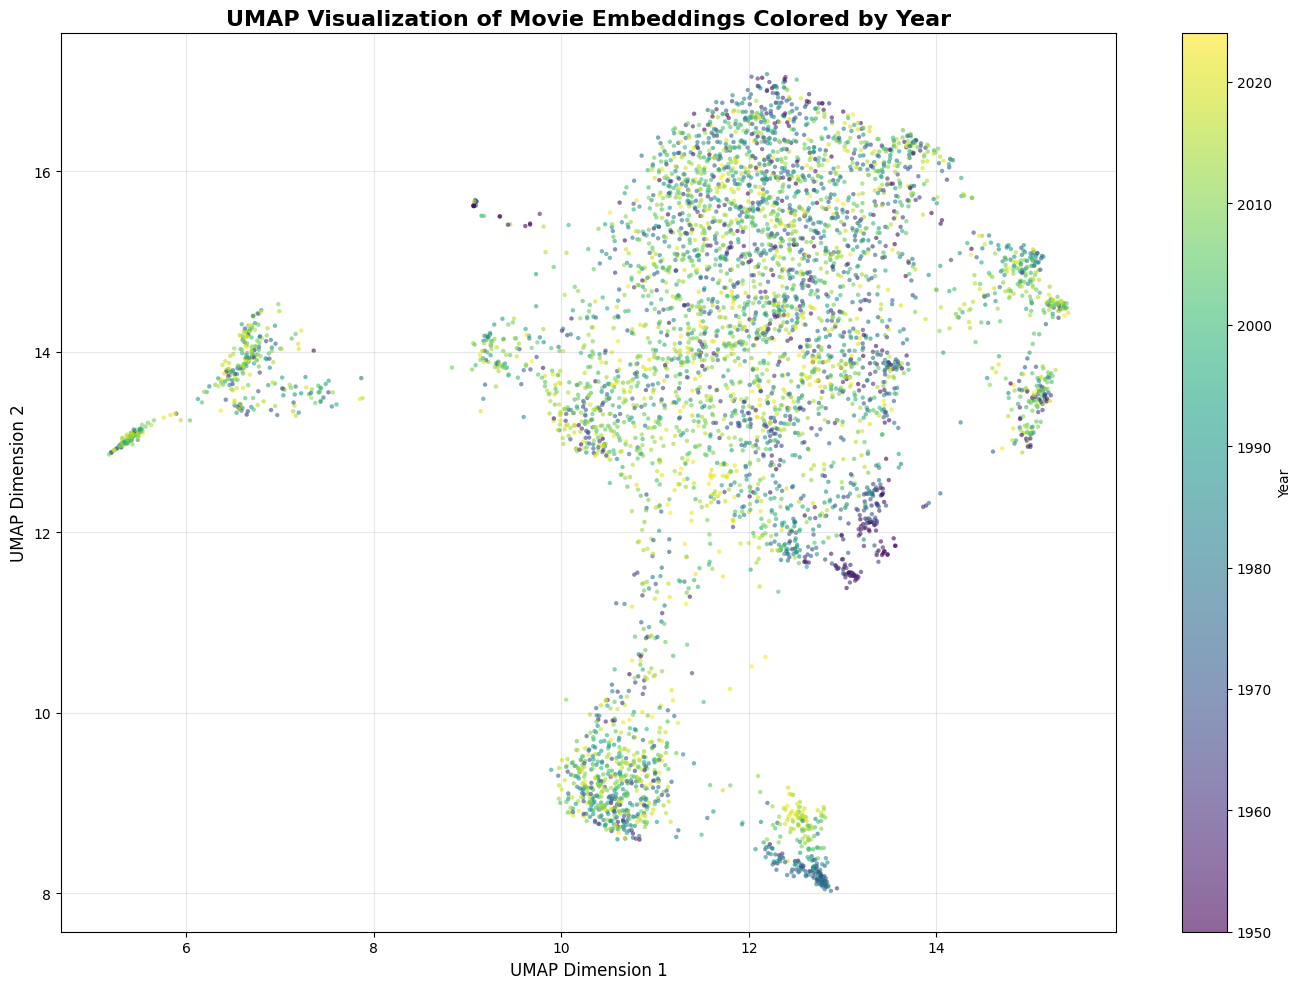

Saved: umap_by_year.png


In [6]:
# Plot 1: Colored by year with gradient
plt.figure(figsize=(14, 10))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], 
                     c=sampled_years, cmap='viridis', 
                     s=10, alpha=0.6, edgecolors='none')
plt.colorbar(scatter, label='Year')
plt.title('UMAP Visualization of Movie Embeddings Colored by Year', fontsize=16, fontweight='bold')
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'umap_by_year.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Saved: umap_by_year.png")


/tmp/ipykernel_74468/1371722855.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


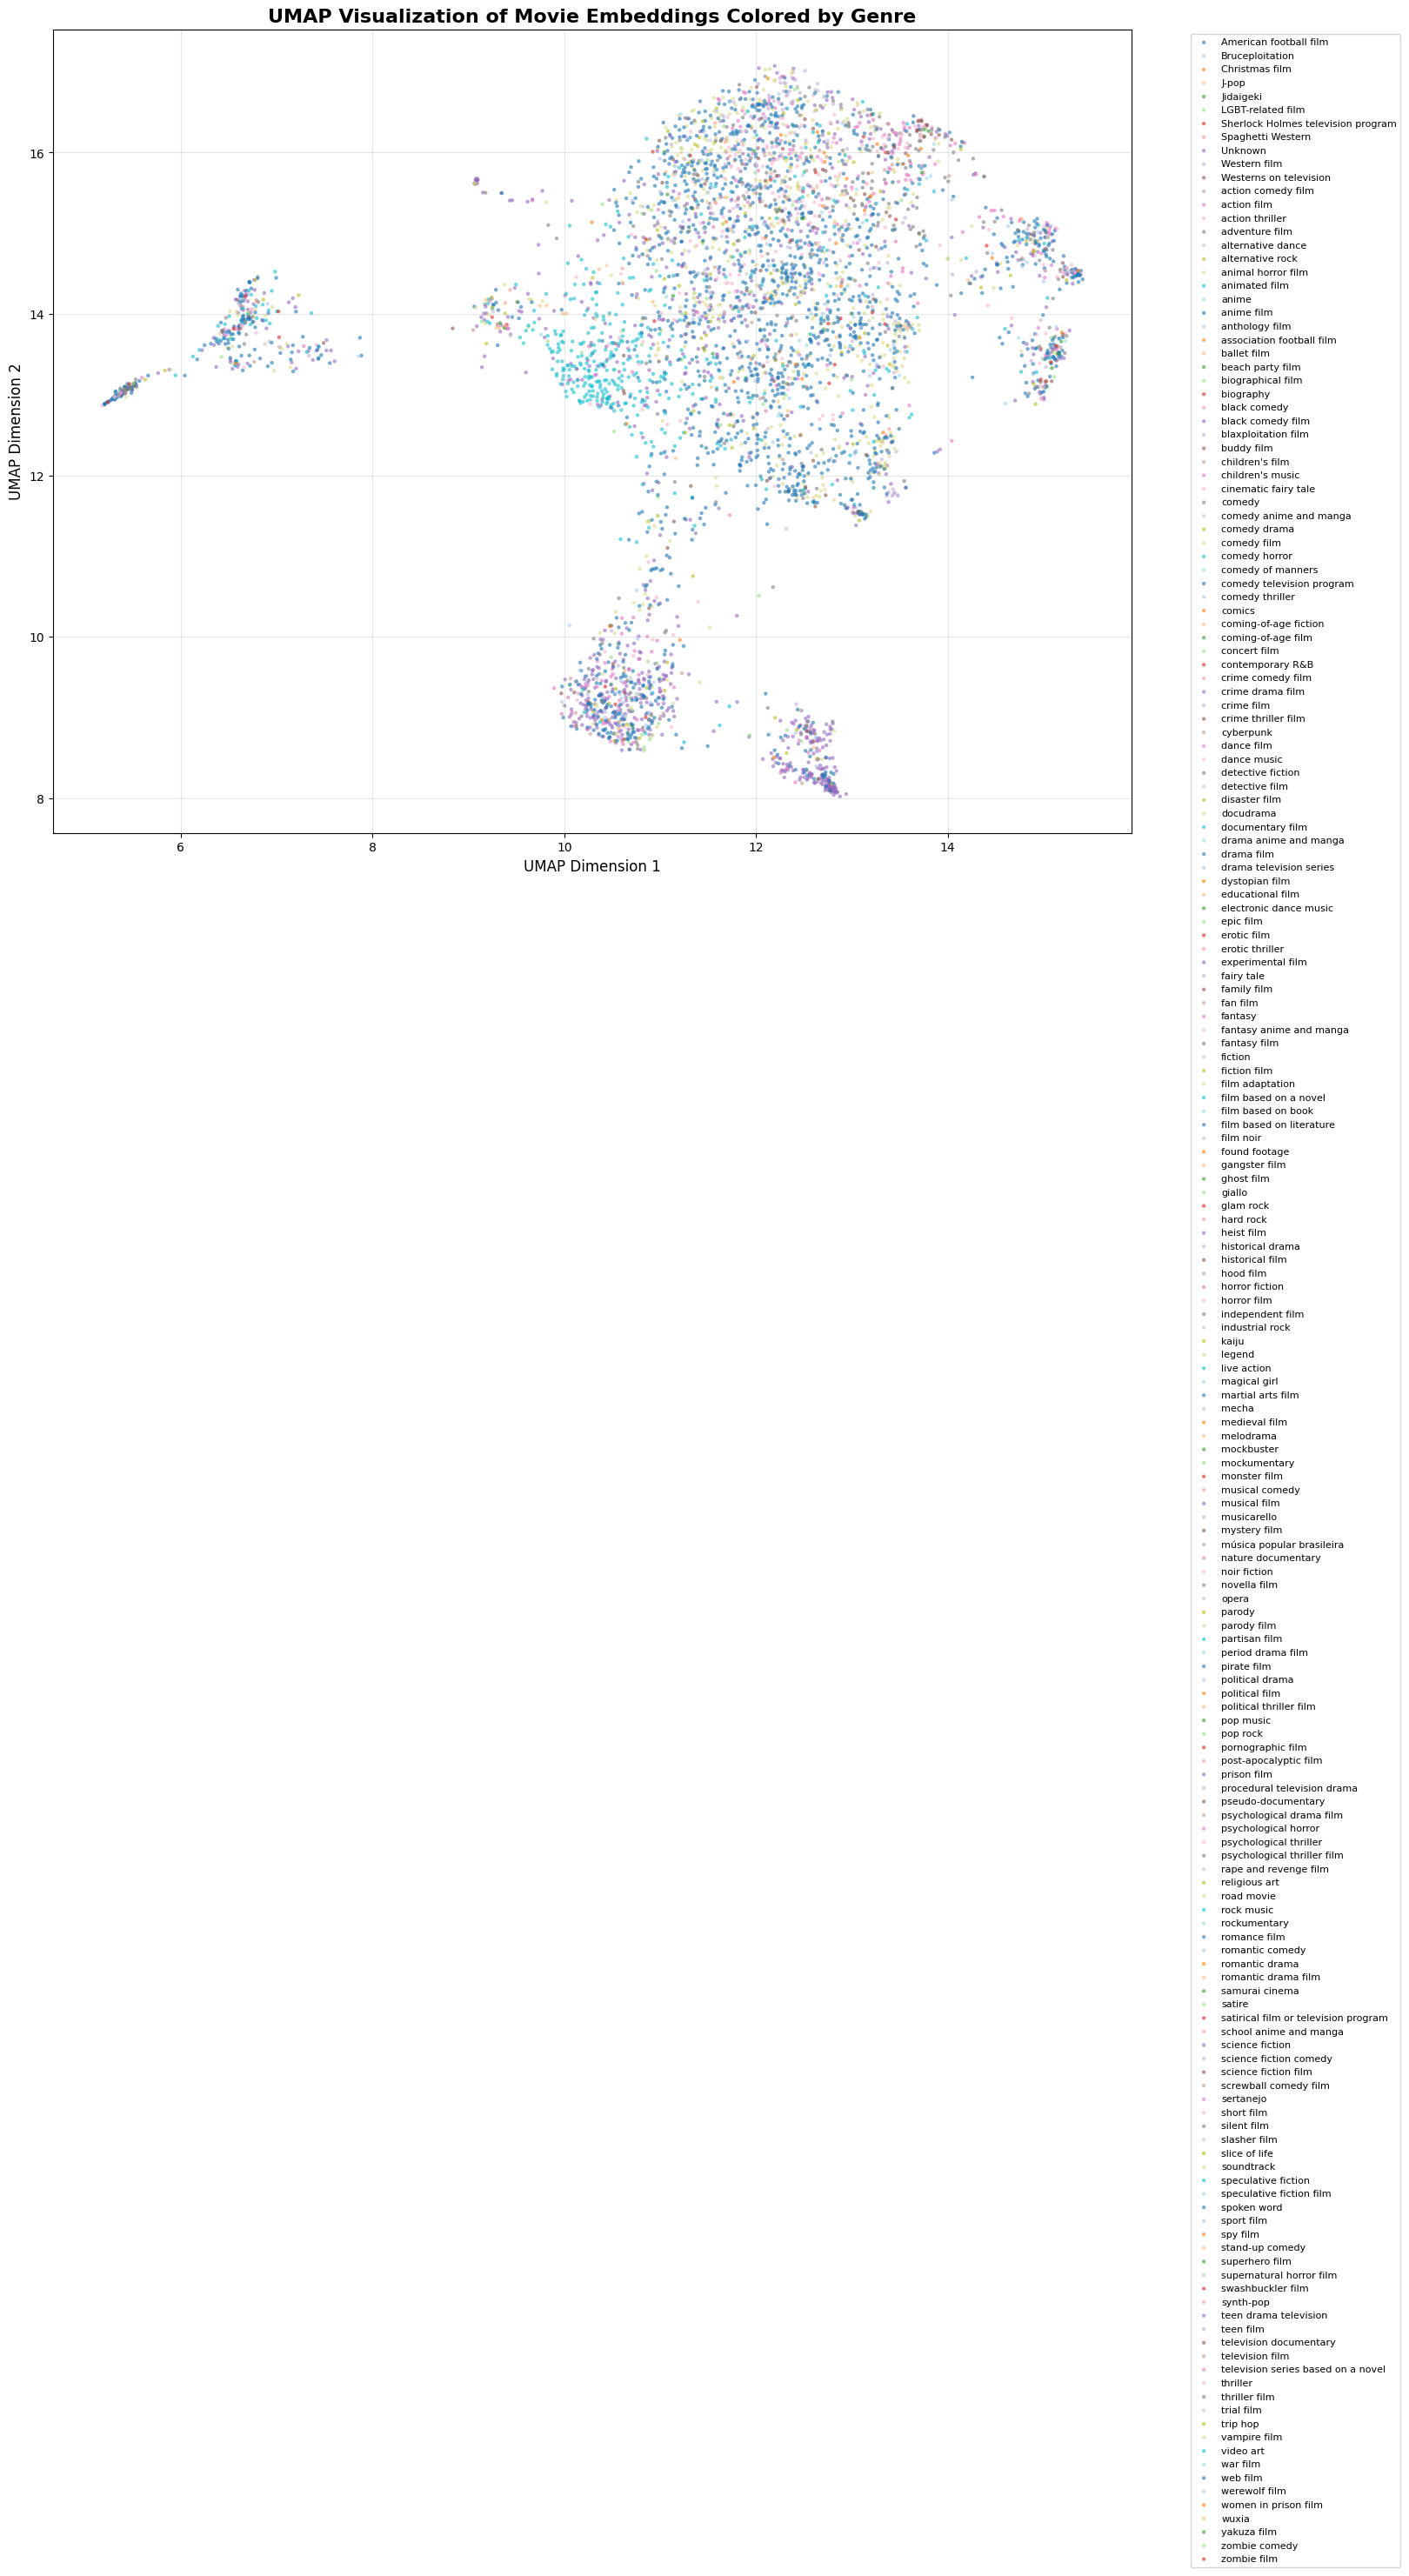

Saved: umap_by_genre.png


In [7]:
# Plot 2: Colored by genre
plt.figure(figsize=(16, 12))

# Get unique genres and assign colors
unique_genres = sorted(set(sampled_genres))
n_genres = len(unique_genres)

# Use a colormap with enough colors
colors = plt.cm.tab20(np.linspace(0, 1, 20))
if n_genres > 20:
    # Cycle through colors if we have more than 20 genres
    color_map = {genre: colors[i % 20] for i, genre in enumerate(unique_genres)}
else:
    color_map = {genre: colors[i] for i, genre in enumerate(unique_genres)}

# Plot each genre with its color
for genre in unique_genres:
    mask = np.array(sampled_genres) == genre
    plt.scatter(umap_embedding[mask, 0], umap_embedding[mask, 1], 
               c=[color_map[genre]], label=genre, s=10, alpha=0.6, edgecolors='none')

plt.title('UMAP Visualization of Movie Embeddings Colored by Genre', fontsize=16, fontweight='bold')
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'umap_by_genre.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Saved: umap_by_genre.png")


In [8]:
print("Analysis complete!")
print(f"\nSummary:")
print(f"  Total movies loaded: {len(all_movie_ids)}")
print(f"  Movies sampled: {n_samples}")
print(f"  Year range: {all_years.min()} - {all_years.max()}")
print(f"  Unique genres: {len(set(sampled_genres))}")
print(f"\nPlots saved to:")
print(f"  {os.path.join(DATA_DIR, 'umap_by_year.png')}")
print(f"  {os.path.join(DATA_DIR, 'umap_by_genre.png')}")


Analysis complete!

Summary:
  Total movies loaded: 161553
  Movies sampled: 5000
  Year range: 1950 - 2024
  Unique genres: 187

Plots saved to:
  /home/nab/GroupDataLiteracy/data/umap_by_year.png
  /home/nab/GroupDataLiteracy/data/umap_by_genre.png
